In [1]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib as mpl
# mpl.use('macosx')

import matplotlib.pyplot as plt
plt.ion()

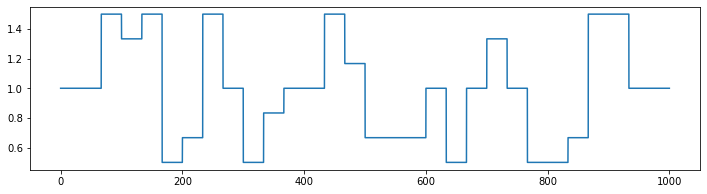

In [2]:
L = 1000  # the length of simulation path
Parts = 30  # parts of the path
Resolu = 10 # resolution for display
PARTS_L = L/Parts

def generateDiffPlanes(l = 20, parts = 30, heights = 7, lowest = 0.5 , highest = 1.5):
    h = np.linspace(lowest, highest, heights)
    path = h[np.random.randint(0, heights, parts)]
    # print(path)
    return path

# generate the main map
PATH = generateDiffPlanes(L, Parts)
PATH[0] = 1
PATH[1] = 1

Length = np.linspace(0, L, L * Resolu)
Height = np.zeros((L * Resolu))
for i in range(L * Resolu):
    Height[i] = PATH[int(i/Resolu/(PARTS_L))]

plt.figure(figsize=(12,3))
plt.plot(Length, Height)
plt.show()

def x2height(x):
    """
     retrun the ground level at point x
    """
    return PATH[int(x/PARTS_L)]

In [3]:
k = 200
m = 5
l_0 = 5
Delta_l = 0
epsilon = 0
g = 9.8
X_FORWARD = l_0*0.6
H_COLLISION = np.sqrt(l_0*l_0 - X_FORWARD*X_FORWARD)
X_FORWARD  = 0
T_STANCE = 0.5
t_stance = 0.5


parameters = {}
parameters['k'] = k
parameters['l0'] = l_0
parameters['b'] = 0
parameters['m'] = m
parameters['gravity'] = g


def flight_to_stance(state_in, parameters, foot_posi):
    l0 = parameters['l0']
    x_foot, y_foot = foot_posi
    x, x_dot, y, y_dot = state_in
    
    alpha = np.arctan((y - y_foot)/(x_foot - x))
#     print("x_foot - x is " + str(x_foot - x))
    theta_0 = np.pi - alpha
    
    R = np.matrix([[np.cos(theta_0), -np.sin(theta_0)],
                   [np.sin(theta_0),  np.cos(theta_0)]])
    out = R.T*np.matrix([x_dot, y_dot]).T
    r = l0 #- 1E-7 # this enforces that only the liftoff event is detected
    theta = theta_0
    r_dot = out[0,0]
    theta_dot = (1/r)*out[1,0]
                   
    state = [r,
             r_dot,
             theta, 
             theta_dot]
    return state


def dynamics_stance(t, state, parameters):
    k = parameters['k']
    l0 = parameters['l0']
    b = parameters['b']
    m = parameters['m']
    g = parameters['gravity']
    
    r, r_dot, theta, theta_dot = state
    
    state_dt = [r_dot, 
                r*theta_dot**2 - (k/m)*(r - l0 ) - b*r_dot - g*np.sin(theta),
                theta_dot, 
                (-2*r_dot*theta_dot + g*np.cos(theta))/r]
    return state_dt

def flight_step(t, state):
    x, x_dot,y, y_dot = state
    
    return [x_dot,0, y_dot, -g]
    
def end_flight_event(t, state):
    try:
        if (state[3] > 0):
            return 1
        height_ground = x2height(state[0] + X_FORWARD)
    except:
        # if reach the end of map
        return -1
        
    return state[2] - height_ground - H_COLLISION # 4.582575694

end_flight_event.terminal = True   
    

def end_stance_event(t, state) :   
    r, _, _, _ = state
    return r - l_0 - 0.000001

end_stance_event.terminal = True  

In [4]:
def xf_control(v, vd, Tp, kv, ki,v_serie ):
    xf = 0
    xf += ki*np.sum(v_serie - vd)
    xf += v*Tp/2 + kv*(v - vd)
    xf = min(xf , 0.6*l_0)
    xf = max(xf,  0.01*l_0)

    
    return xf
    


In [5]:
print(np.sqrt(l_0*l_0 - X_FORWARD*X_FORWARD))

5.0


In [6]:
H_COLLISION = 0
def simulate_hop(t,state,t0 ):
    # flight phase
    long_time = 100
    time_series = np.linspace(0, long_time, int(long_time/0.0001))
    
    end_flight_lambda = lambda t, state: end_flight_event(t, state)
    end_flight_lambda.terminal = True
    
    sol = solve_ivp(lambda t, state: flight_step(t, state),
                   [t0, t0+long_time],state,
                   events = end_flight_lambda,
                   t_eval = t0+time_series,
                   rtol = 1e-10, atol=1e-10,
                   dense_output = True,
                   method = 'RK45',
                   max_step = 1)
    land_state = sol.y[:,-1]
    
    out_state = sol.y
    time = sol.t
    
        
    try:
        foot_posi = [land_state[0] + X_FORWARD, x2height(land_state[0] + X_FORWARD)  ]  # x, y position of the touch point
    except:
         # if reach the end of map
        return time, out_state, 0, land_state ,[0,0]
    
    # stance phase
    stance_state = flight_to_stance(land_state, parameters, foot_posi)

    end_stance_lambda = lambda t, state: end_stance_event(t, state)
    end_stance_lambda.terminal = True
    
    sol = solve_ivp(lambda t, state: dynamics_stance(t, state, parameters),
               [time[-1], time[-1]+long_time],stance_state,
               events = end_stance_lambda,
               t_eval = time[-1]+time_series,
               rtol = 1e-10, atol=1e-10,
               dense_output = True,
               method = 'RK45',
               max_step = 1)

    # polar to Cartesian coordinates
    sol_cart = np.zeros(sol.y.shape)
    sol_cart[0] =  sol.y[0]*np.cos(sol.y[2]) + foot_posi[0]  # x
    sol_cart[1] =  -sol.y[0]*sol.y[3]*np.sin(sol.y[2]) + sol.y[1]*np.cos(sol.y[2])   # x_dot
    sol_cart[2] =  sol.y[0]*np.sin(sol.y[2]) + foot_posi[1]  # y
    sol_cart[3] =  sol.y[0]*sol.y[3]*np.cos(sol.y[2]) + sol.y[1]*np.sin(sol.y[2])   # x_dot
    

    out_state = np.hstack((out_state, sol_cart))
    t_stance = sol.t[-1] - sol.t[0] # stance time
    time = np.hstack((time, sol.t))
    
    return time, out_state, t_stance, land_state ,foot_posi

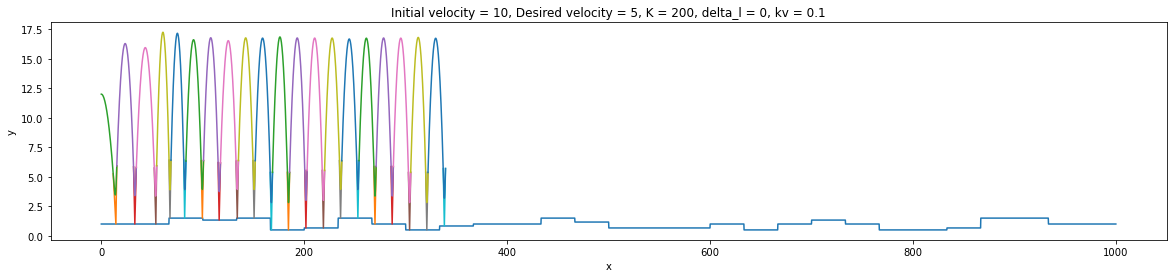

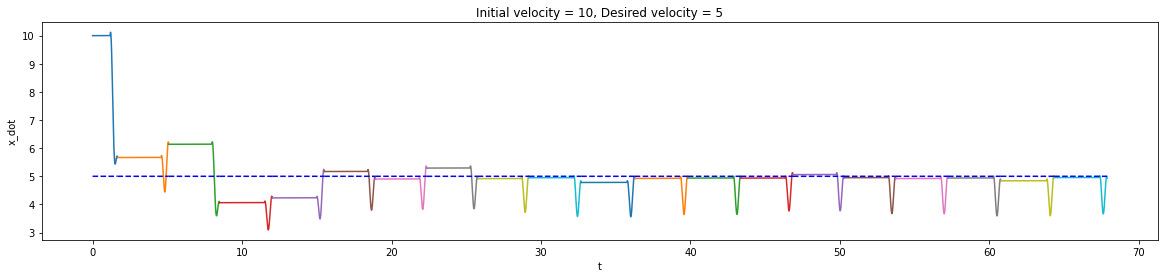

The velocity in final hop is 4.954468801114566


In [7]:
initial_velocity = 10
Original_velocity_dersired  = 5

system_error = 0.85
velocity_dersired = Original_velocity_dersired + system_error


initial_velo = initial_velocity
initial_time = 0

plt.figure(figsize = (20,4))
plt.plot(Length, Height)

# with a larger initial height, we can control the velocity to a larger range
it_initial_state = [0, initial_velo, l_0 + 7, 0]   # x x_dot y y_dot 
kv = 0.1
ki = 0.0157
t_stance = 0.5

v_serie = np.zeros(3)

t_list = []
x_velocity_list = []
iteration = 20

# main iterator
for i in range(iteration):
    # calculate the desired x_f
    X_FORWARD = xf_control(it_initial_state[1], velocity_dersired, t_stance, kv, ki, v_serie)
    H_COLLISION = np.sqrt(l_0*l_0 - X_FORWARD*X_FORWARD)
    
    # calculate the state for one hop
    time, out_state, t_stance, land_state ,foot_posi =  simulate_hop(0, it_initial_state, initial_time)
    if(t_stance == 0):
        print("Reached the end of map !!" )
        break
    t_list.append(time)
    x_velocity_list.append(out_state[1])
    
    # print the x,y trajectory for one hop
    y = out_state[2]
    x = out_state[0]
    x_foot_series = np.array([land_state[0], foot_posi[0], out_state[0,-1]])
    y_foot_series = np.array([land_state[2], foot_posi[1], out_state[2,-1]])
    plt.plot(x_foot_series, y_foot_series)
    plt.plot(x, y)
    
    initial_time = time[-1]
    it_initial_state = out_state[:,-1]
    
    v_serie[1:] = v_serie[:-1]
    v_serie[0] = out_state[1,0]

    
plt.xlabel("x")
plt.ylabel("y")
title = "Initial velocity = " + str(initial_velocity) + ", Desired velocity = " + str(Original_velocity_dersired) + ", K = " + str(k) + ", delta_l = " + str(Delta_l)
title = title + ", kv = " + str(kv)
plt.title(title)
plt.show()

# print the velocity-time chart
plt.figure(figsize = (20,4))
for i in range(len(t_list)):
    plt.plot(t_list[i], x_velocity_list[i])
    plt.plot(t_list[i],  np.zeros(t_list[i].shape) + Original_velocity_dersired,'--',color='b')
plt.xlabel("t")
plt.ylabel("x_dot")   
plt.title("Initial velocity = " + str(initial_velocity) + ", Desired velocity = " + str(Original_velocity_dersired))
plt.show()    


print("The velocity in final hop is " + str(x_velocity_list[i][0]))


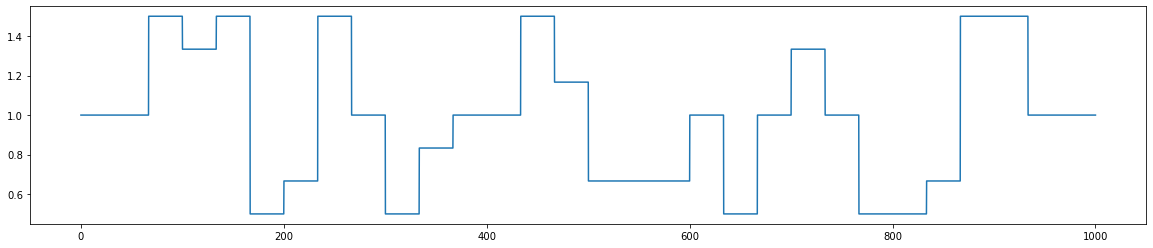

In [8]:
initial_velocity = 10
Original_velocity_dersired  = 11

system_error = 0.85
velocity_dersired = Original_velocity_dersired + system_error


initial_velo = initial_velocity
initial_time = 0

plt.figure(figsize = (20,4))
plt.plot(Length, Height)

# with a larger initial height, we can control the velocity to a larger range
it_initial_state = [0, initial_velo, l_0 + 7, 0]   # x x_dot y y_dot 
kv = 0.1
ki = 0.0157
v_serie = np.zeros(3)


def flight_step(t, state):
    x, x_dot,y, y_dot = state
    
#     vvelocity_dersired = velocity_dersired_series[int(initial_time/25)] + system_error
#     X_FORWARD = xf_control(x_dot, velocity_dersired, t_stance, kv, ki, v_serie)
#     H_COLLISION = np.sqrt(l_0*l_0 - X_FORWARD*X_FORWARD)
    
    
    return [x_dot,0, y_dot, -g]

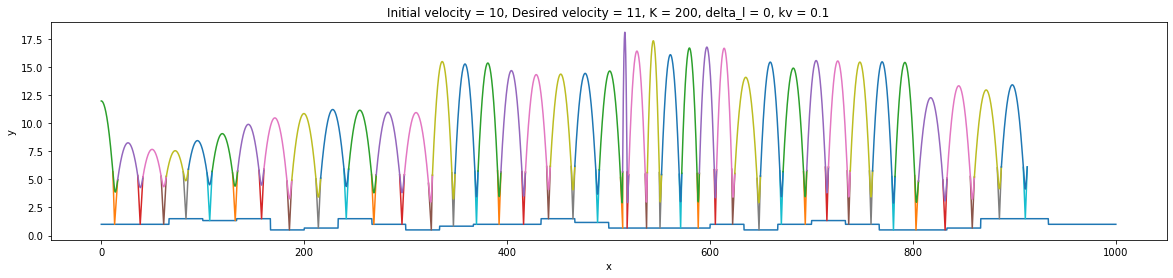

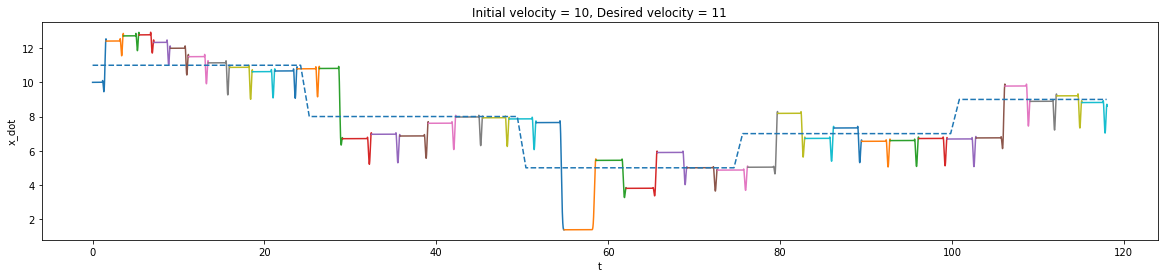

In [9]:
initial_velocity = 10
Original_velocity_dersired  = 11

system_error = 0.85
velocity_dersired = Original_velocity_dersired + system_error


initial_velo = initial_velocity
initial_time = 0

plt.figure(figsize = (20,4))
plt.plot(Length, Height)

# with a larger initial height, we can control the velocity to a larger range
it_initial_state = [0, initial_velo, l_0 + 7, 0]   # x x_dot y y_dot 
kv = 0.1
ki = 0.0157
t_stance = 0.5



t_list = []
x_velocity_list = []
iteration = 40
velocity_dersired_series = [11, 8, 5, 7, 9, 6]
# main iterator
for i in range(iteration):
    # calculate the desired x_f
    
    X_FORWARD = xf_control(it_initial_state[1], velocity_dersired, t_stance, kv, ki, v_serie)
    H_COLLISION = np.sqrt(l_0*l_0 - X_FORWARD*X_FORWARD)
    
    # calculate the state for one hop
    time, out_state, t_stance, land_state ,foot_posi =  simulate_hop(0, it_initial_state, initial_time)
    if(t_stance == 0):
        print("Reached the end of map !!" )
        break
    t_list.append(time)
    x_velocity_list.append(out_state[1])
    
    # print the x,y trajectory for one hop
    y = out_state[2]
    x = out_state[0]
    x_foot_series = np.array([land_state[0], foot_posi[0], out_state[0,-1]])
    y_foot_series = np.array([land_state[2], foot_posi[1], out_state[2,-1]])
    plt.plot(x_foot_series, y_foot_series)
    plt.plot(x, y)
    
    initial_time = time[-1]
    it_initial_state = out_state[:,-1]
    
    v_serie[1:] = v_serie[:-1]
    v_serie[0] = out_state[1,0]
    
    velocity_dersired = velocity_dersired_series[int(initial_time/25)] + system_error

    
plt.xlabel("x")
plt.ylabel("y")
title = "Initial velocity = " + str(initial_velocity) + ", Desired velocity = " + str(Original_velocity_dersired) + ", K = " + str(k) + ", delta_l = " + str(Delta_l)
title = title + ", kv = " + str(kv)
plt.title(title)
plt.show()

# print the velocity-time chart
plt.figure(figsize = (20,4))
for i in range(len(t_list)):
    plt.plot(t_list[i], x_velocity_list[i])
plt.xlabel("t")
plt.ylabel("x_dot")   
plt.title("Initial velocity = " + str(initial_velocity) + ", Desired velocity = " + str(Original_velocity_dersired))


runtime = int(time[-1])
desired_velo_seq = np.zeros(runtime)
for i in range(runtime):
    desired_velo_seq[i] = velocity_dersired_series[int(i/25)]
plt.plot(np.linspace(0, runtime, runtime), desired_velo_seq,'--')


plt.show()    





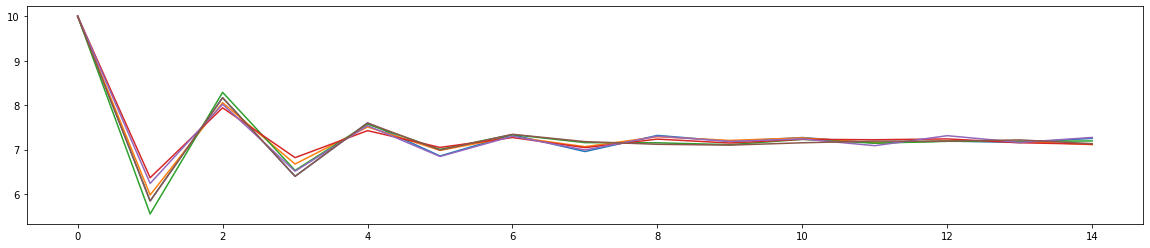

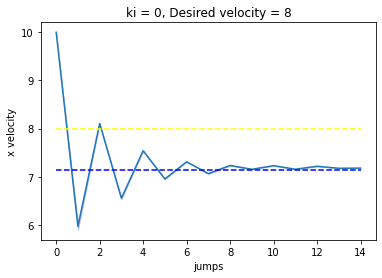

mean = 7.132063712482143
var = 0.20718280317305285


In [10]:


initial_velocity = 10
Original_velocity_dersired  = 8

system_error = 0.85
velocity_dersired = Original_velocity_dersired + system_error


initial_velo = initial_velocity


# plt.figure(figsize = (20,4))
# plt.plot(Length, Height)

# with a larger initial height, we can control the velocity to a larger range
it_initial_state = [0, initial_velo, l_0 + 7, 0]   # x x_dot y y_dot 
kv = 0.1
ki = 0.0157
ki = 0

t_list = []
x_velocity_list = []
iteration = 15
repeat = 6

x_dot_buffer = []


plt.figure(figsize = (20,4))
for j in range(repeat):
    
    v_serie = np.zeros(3)
    it_initial_state = [0, initial_velo, l_0 + 7, 0]   # x x_dot y y_dot 
    x_air_velo = []
    initial_time = 0
    t_stance = 0.5
    
    generateDiffPlanes( lowest = 0.5 , highest = 3.5)
    PATH = generateDiffPlanes(L, Parts)
    
    
    for i in range(iteration):
        
        # calculate the desired x_f
        X_FORWARD = xf_control(it_initial_state[1], velocity_dersired, t_stance, kv, ki, v_serie)
        H_COLLISION = np.sqrt(l_0*l_0 - X_FORWARD*X_FORWARD)

        # calculate the state for one hop
        time, out_state, t_stance, land_state ,foot_posi =  simulate_hop(0, it_initial_state, initial_time)
        if(t_stance == 0):
            print("Reached the end of map !!" )
            break
        t_list.append(time)
        x_velocity_list.append(out_state[1])

        # print the x,y trajectory for one hop
        y = out_state[2]
        x = out_state[0]
        x_foot_series = np.array([land_state[0], foot_posi[0], out_state[0,-1]])
        y_foot_series = np.array([land_state[2], foot_posi[1], out_state[2,-1]])
    #     plt.plot(x_foot_series, y_foot_series)
    #     plt.plot(x, y)

        initial_time = time[-1]
        it_initial_state = out_state[:,-1]

        v_serie[1:] = v_serie[:-1]
        v_serie[0] = out_state[1,0]
        
        x_air_velo.append(out_state[1,0])
    plt.plot(np.array(x_air_velo))
    x_dot_buffer.append(x_air_velo)
plt.show()
    
# plt.xlabel("x")
# plt.ylabel("y")
# title = "Initial velocity = " + str(initial_velocity) + ", Desired velocity = " + str(Original_velocity_dersired) + ", K = " + str(k) + ", delta_l = " + str(Delta_l)
# title = title + ", kv = " + str(kv)
# plt.title(title)
# plt.show()


x_dot_buffer = np.array(x_dot_buffer)

x_dot_buffer_mean = np.mean(x_dot_buffer, axis = 0)
x_dot_buffer_var = np.var(x_dot_buffer, axis = 0)
series = np.linspace(0, iteration-1, iteration)
plt.plot(series, x_dot_buffer_mean)
plt.fill_between(series, x_dot_buffer_mean - x_dot_buffer_var, x_dot_buffer_mean + x_dot_buffer_var, color = 'b', alpha = 0.2)
plt.xlabel('jumps')
plt.ylabel('x velocity')
plt.title('ki = ' + str(ki) + ", Desired velocity = " + str(Original_velocity_dersired))

vx_mean = np.mean(x_dot_buffer_mean[1:])
vx_var = np.var(x_dot_buffer_mean[1:])
plt.plot(series, np.zeros(iteration) + vx_mean, '--', color = 'blue')
plt.plot(series, np.zeros(iteration) + Original_velocity_dersired, '--', color = 'yellow')
plt.show()
print("mean = " + str(vx_mean))
print("var = " + str(vx_var))
# plt.figure()

# plt.xlabel('jumps')
# plt.ylabel('x velocity')
# plt.title('ki = ' + str(ki))
# plt.show()

# plt.figure(figsize = (20,4))
# for x_dot in x_dot_buffer:
#     plt.plot(np.array(x_dot))
# plt.show()

# print the velocity-time chart
# plt.figure(figsize = (20,4))
# for i in range(len(t_list)):
#     plt.plot(t_list[i], x_velocity_list[i])
#     plt.plot(t_list[i],  np.zeros(t_list[i].shape) + Original_velocity_dersired,'--',color='b')
# plt.xlabel("t")
# plt.ylabel("x_dot")   
# plt.title("Initial velocity = " + str(initial_velocity) + ", Desired velocity = " + str(Original_velocity_dersired)  + " ki = " + str(ki))
# plt.show()    


# print("The velocity in final hop is " + str(x_velocity_list[i][0]))


In [13]:
# plt.plot(Time, sets_x_vel_mean)
# plt.fill_between(Time, sets_x_vel_mean - sets_x_vel_std, sets_x_vel_mean + sets_x_vel_std, color = 'b', alpha = 0.2)
# plt.plot(Time, desried_x_dot,'--')
# plt.plot(Time, -desried_x_dot,'--')
# plt.xlabel('Time')
# plt.ylabel('leg x_body velocity')